# Disease Associates Genes Edge Prediction

This notebook is designed to take the next step moving from predicted sentences to edge predictions. After training the discriminator model, each sentences contains a confidence score for the likelihood of mentioning a relationship. Multiple relationships contain multiple sentences, which makes establishing an edge unintuitive. Is taking the max score appropiate for determining existence of an edge? Does taking the mean of each relationship make more sense? The answer towards these questions are shown below.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

sys.path.append(os.path.abspath('../../../modules'))

from utils.notebook_utils.dataframe_helper import mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
total_candidates_df = (
    pd
    .read_csv("input/all_dag_candidates.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
total_candidates_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,candidate_id,sentence_id,text,sen_length
82343,189,AGXT,DOID:2531,hematologic cancer,NaN,0,2668,1,0.88258,1,21421,553297,A review of the literature since the use of ch...,39
1773121,3630,INS,DOID:1793,pancreatic cancer,NaN,0,1763,1,0.19694,0,21422,635063,The presence of insulin antibodies did not imp...,14


In [6]:
sentence_prediction_df = (
    pd
    .read_csv("input/all_predicted_dag_sentences.tsv.xz", sep="\t")
    .sort_values("candidate_id")
)
sentence_prediction_df.head(2)

,candidate_id,pred
0,21421,0.544230
1,21422,0.452499


In [7]:
# DataFrame that combines likelihood scores with each candidate sentence
total_candidates_pred_df = (
    total_candidates_df[[
    "doid_id", "doid_name", 
    "entrez_gene_id", "gene_symbol", 
    "text", "hetionet",
    "candidate_id", "split"
    ]]
    .merge(sentence_prediction_df, on="candidate_id")
)

#total_candidates_pred_df.to_csv(
#    "output/combined_predicted_dag_sentences.tsv.xz", 
#    sep="\t", index=False, compression="xz"
#)

total_candidates_pred_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,text,hetionet,candidate_id,split,pred
0,DOID:2531,hematologic cancer,189,AGXT,A review of the literature since the use of ch...,0,21421,1,0.544230
1,DOID:1793,pancreatic cancer,3630,INS,The presence of insulin antibodies did not imp...,0,21422,0,0.452499


In [8]:
# DataFrame that groups disease and gene mentions together and takes
# the max, median and mean of each group
grouped_candidates_pred_df=(
    total_candidates_pred_df
    .groupby(["doid_id", "entrez_gene_id"], as_index=False)
    .agg({
        "pred": ['max', 'mean', 'median'], 
        'hetionet': 'first',
        "gene_symbol": 'first',
        "doid_name": 'first',
        "split": 'first'
    })
)
grouped_candidates_pred_df.head(2)

doid_id entrez_gene_id      pred                     hetionet  \
                                     max      mean    median    first   
0  DOID:0050156              2  0.445878  0.434481  0.434481        0   
1  DOID:0050156             16  0.634072  0.590702  0.589147        0   

  gene_symbol                      doid_name split  
        first                          first first  
0         A2M  idiopathic pulmonary fibrosis     2  
1        AARS  idiopathic pulmonary fibrosis     2

In [9]:
grouped_candidates_pred_df.columns = [
    "_".join(col) 
    if col[1] != '' and col[0] not in ['hetionet', 'gene_symbol', 'doid_name', 'split'] else col[0] 
    for col in grouped_candidates_pred_df.columns.values
]

grouped_candidates_pred_df.head(2)

,doid_id,entrez_gene_id,pred_max,pred_mean,pred_median,hetionet,gene_symbol,doid_name,split
0,DOID:0050156,2,0.445878,0.434481,0.434481,0,A2M,idiopathic pulmonary fibrosis,2
1,DOID:0050156,16,0.634072,0.590702,0.589147,0,AARS,idiopathic pulmonary fibrosis,2


In [10]:
grouped_candidates_pred_subet_df = (
    grouped_candidates_pred_df
    .query("split==2")
    .drop("split", axis=1)
)
grouped_candidates_pred_subet_df.head(2)

,doid_id,entrez_gene_id,pred_max,pred_mean,pred_median,hetionet,gene_symbol,doid_name
0,DOID:0050156,2,0.445878,0.434481,0.434481,0,A2M,idiopathic pulmonary fibrosis
1,DOID:0050156,16,0.634072,0.590702,0.589147,0,AARS,idiopathic pulmonary fibrosis


In [11]:
grouped_candidates_pred_subet_df.hetionet.value_counts()

0    13928
1      943
Name: hetionet, dtype: int64

# Best Sentence Representation Metric

This section aims to answer the question: What metric (Mean, Max, Median) best predicts Hetionet Edges?

In [12]:
performance_map = {}

In [13]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_max,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_max,
)

performance_map['max'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [14]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_mean,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_mean,
)

performance_map['mean'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

In [15]:
precision, recall, pr_threshold = precision_recall_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_median,
)

fpr, tpr, roc_threshold = roc_curve(
    grouped_candidates_pred_subet_df.hetionet, 
    grouped_candidates_pred_subet_df.pred_median,
)

performance_map['median'] = {
    "precision":precision, "recall":recall, 
    "pr_threshold":pr_threshold, "false_pos":fpr,
    "true_pos":tpr, "roc_threshold":roc_threshold, 
}

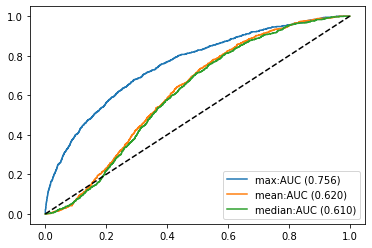

In [16]:
for key in performance_map:
    plt.plot(
        performance_map[key]['false_pos'], 
        performance_map[key]['true_pos'], 
        label=f"{key}:AUC ({auc(performance_map[key]['false_pos'], performance_map[key]['true_pos']):.3f})"
    )
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.legend()
plt.show()

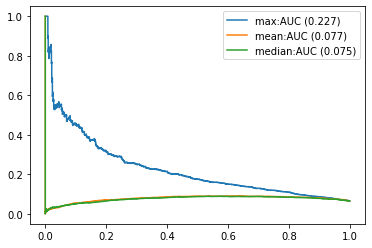

In [17]:
for key in performance_map:
    plt.plot(
        performance_map[key]['recall'], 
        performance_map[key]['precision'], 
        label=f"{key}:AUC ({auc(performance_map[key]['recall'], performance_map[key]['precision']):.3f})"
    )

plt.legend()
plt.show()

# Optimal Cutoff Using PR-CURVE 

In [18]:
threshold_df = (
    pd.DataFrame(
        list(
            zip(
                performance_map['max']['precision'], 
                performance_map['max']['recall'], 
                performance_map['max']['pr_threshold']
            )
        ),
        columns=["precision", "recall", "pr_threshold"]
    )
    .sort_values("precision", ascending=False)
)
threshold_df.head(2)

,precision,recall,pr_threshold
14252,1.0,0.001060,0.947382
14251,1.0,0.002121,0.936937


In [19]:
#precision_thresholds = pd.np.linspace(0,1,num=5)
precision_thresholds = threshold_df.round(2).drop_duplicates("precision").precision.values

# Add the lowest precision rather than
# Keep it zero
precision_thresholds = (
    pd.np.where(
        precision_thresholds==0, 
        threshold_df.precision.min(), 
        precision_thresholds
    )
)

performance_records = []
for precision_cutoff in precision_thresholds:

    cutoff = (
        threshold_df
        .query("precision>=@precision_cutoff")
        .pr_threshold
        .min()
    )
    
    values_added = (
        grouped_candidates_pred_subet_df
        .query("pred_max >= @cutoff")
        .hetionet
        .value_counts()
    )
    
    series_keys = list(values_added.keys())
    for key in series_keys:
        performance_records.append(
           {  
               "edges": values_added[key], 
               "in_hetionet": "Existing" if key == 1 else "Novel", 
               "precision": precision_cutoff,
               "sen_cutoff": cutoff
           }
        )
   
    
edges_added_df = (
    pd
    .DataFrame
    .from_records(performance_records)
)
edges_added_df.head(10)

,edges,in_hetionet,precision,sen_cutoff
0,8,Existing,1.00,0.922116
1,9,Existing,0.90,0.918376
2,1,Novel,0.90,0.918376
3,9,Existing,0.89,0.918376
4,1,Novel,0.89,0.918376
5,9,Existing,0.86,0.918376
6,1,Novel,0.86,0.918376
7,18,Existing,0.85,0.911369
8,3,Novel,0.85,0.911369
9,18,Existing,0.84,0.911369


[None]

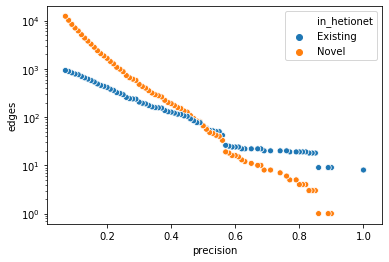

In [20]:
ax = sns.scatterplot(x="precision", y="edges", hue="in_hetionet", data=edges_added_df)
ax.set(yscale="log")

In [21]:
edges_added_df.to_csv("output/precision_dag_edges_added.tsv", index=False, sep="\t")

# Total Recalled Edges

How many edges of hetionet can we recall using an equal error rate cutoff score?

In [22]:
def tag_sentence(x):
    candidates=(
        session
        .query(DiseaseGene)
        .filter(DiseaseGene.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [23]:
gen_pred_df = (
    pd.read_csv("../label_sampling_experiment/results/DaG/marginals/train/30_sampled_train.tsv.xz", sep="\t")
    .iloc[:, [0,-1]]
    .append(
        pd.read_csv("../label_sampling_experiment/results/DaG/marginals/tune/30_sampled_dev.tsv", sep="\t")
        .iloc[:, [0,-1]]
    )
    .append(
        pd.read_csv("../label_sampling_experiment/results/DaG/marginals/test/30_sampled_test.tsv", sep="\t")
        .iloc[:, [0,-1]]
    )
)
gen_pred_df.columns = ["gen_pred", "candidate_id"]
gen_pred_df.head(2)

,gen_pred,candidate_id
0,0.98058,21422
1,1.00000,21427


In [24]:
(
    total_candidates_pred_df.iloc[
        total_candidates_pred_df
        .groupby(["doid_id", "entrez_gene_id"], as_index=False)
        .agg({
            "pred": 'idxmax'
        })
        .pred
    ]
    .merge(gen_pred_df, on=["candidate_id"])
    .assign(edge_type="DaG")
    .sort_values("pred", ascending=False)
    .head(10)
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .merge(total_candidates_df[["n_sentences", "candidate_id"]], on="candidate_id")
    .sort_values("pred", ascending=False)
    .assign(hetionet=lambda x: x.hetionet.apply(lambda x: "Existing" if x == 1 else "Novel"))
    [["edge_type", "doid_name", "gene_symbol", "gen_pred", "pred", "n_sentences", "hetionet", "text"]]
    .to_csv("output/top_ten_edge_predictions.tsv", sep="\t", index=False, float_format="%.3g")
)

In [25]:
datarows = []
fpr, tpr, threshold = roc_curve(
    grouped_candidates_pred_df.hetionet.values, 
    grouped_candidates_pred_df.pred_max.values
)

fnr = 1 - tpr
optimal_threshold = threshold[pd.np.nanargmin(pd.np.absolute((fnr - fpr)))]

datarows.append({
    "recall":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[1] /
        grouped_candidates_pred_df
        .hetionet.
        value_counts()[1]
    ),
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[1]
    ),
    "in_hetionet": "Existing",
    "total": int(grouped_candidates_pred_df.hetionet.value_counts()[1]),
    "relation":"DaG"
})
datarows.append({
    "edges":(
        grouped_candidates_pred_df
        .query("pred_max > @optimal_threshold")
        .hetionet
        .value_counts()[0]
    ),
    "in_hetionet": "Novel",
    "relation":"DaG"
})
edges_df = pd.DataFrame.from_records(datarows)
edges_df

,recall,edges,in_hetionet,total,relation
0,0.691353,6516,Existing,9425.0,DaG
1,NaN,42986,Novel,NaN,DaG


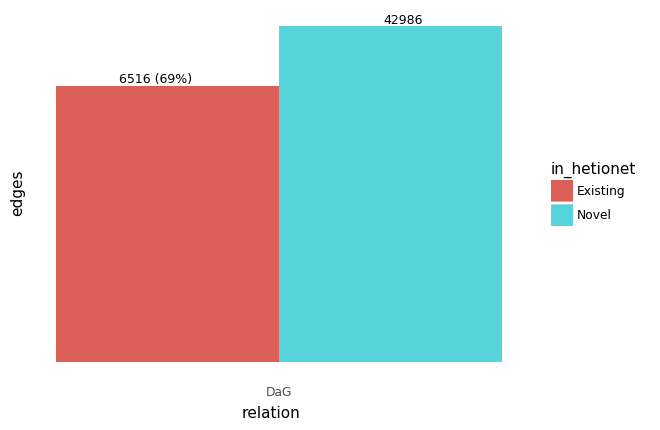

<ggplot: (8733607876058)>


In [26]:
import math
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df
                .apply(
                    lambda x: 
                    f"{x['edges']} ({x['recall']*100:.0f}%)" 
                    if not math.isnan(x['recall']) else 
                    f"{x['edges']}",
                    axis=1
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom"
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major = p9.element_blank(),
        rect=p9.element_blank()
    )
)
print(g)